## Show me your plate and I tell you who you are

#### Unified Package Loading Prelude

In [167]:
import pickle as pkl 
import pandas as pd 
import numpy as np 
import statsmodels as sml
from scipy import stats
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os 
import matplotlib.pyplot as plt

In [ ]:
### In Case we need it, load using the GeoPandas Kernel
import geopandas as gpd



In [222]:
nutrients   = ["energy_fat", "energy_saturate", "energy_sugar", "energy_protein","energy_carb","energy_fibre", "energy_alcohol"]
ethnicities = ["White_perc_2011","Mixed/multiple_ethnic_groups_perc_2011","Asian/Asian_British_perc_2011","Black/African/Caribbean/Black_British_perc_2011","BAME_perc_2011"]
religions   = ["Christian_perc_2011","Buddhist_perc_2011","Hindu_perc_2011","Jewish_perc_2011","Muslim_perc_2011","Sikh_perc_2011","No_religion_perc_2011", "Other_religion_perc_2011"]
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

#### Loading the Data

In [142]:
### Tesco Data
tesco_path = ("Tesco_Data")

lsoa_year     = pd.read_csv(os.path.join(tesco_path, "year_lsoa_grocery.csv"), index_col = "area_id")
msoa_year     = pd.read_csv(os.path.join(tesco_path, "year_msoa_grocery.csv"), index_col = "area_id")
osward_year   = pd.read_csv(os.path.join(tesco_path, "year_osward_grocery.csv"), index_col = "area_id")

In [209]:
# Why don't the name of months follow a lexographical ordering

lsoa_months   = pd.DataFrame()
msoa_months   = pd.DataFrame()
osward_months = pd.DataFrame()


for month in months: 
    
    loading          = pd.read_csv(os.path.join(tesco_path, month +"_lsoa_grocery.csv"), index_col = "area_id")
    loading["month"] = month
    lsoa_months      = lsoa_months.append(loading)
    
    loading          = pd.read_csv(os.path.join(tesco_path, month +"_msoa_grocery.csv"), index_col = "area_id")
    loading["month"] = month
    msoa_months      = msoa_months.append(loading)
    
    loading          = pd.read_csv(os.path.join(tesco_path, month +"_osward_grocery.csv"), index_col = "area_id")
    loading["month"] = month
    osward_months      = osward_months.append(loading)
    
lsoa_months["month"]   = pd.Categorical(lsoa_months['month'], categories=months, ordered=True)
msoa_months["month"]   = pd.Categorical(msoa_months['month'], categories=months, ordered=True)
osward_months["month"] = pd.Categorical(osward_months['month'], categories=months, ordered=True)

In [212]:
### Socio-Economic Data

socio_path = ("Socio_Economic_Data")

lsoa_social     = pd.read_csv(os.path.join(socio_path, "lsoa-data.csv"), encoding = "latin-1", index_col = "Lower Super Output Area")
msoa_social     = pd.read_csv(os.path.join(socio_path, "msoa-data.csv"), encoding = "latin-1", index_col = "Middle Super Output Area")
osward_social   = pd.read_csv(os.path.join(socio_path, "ward-atlas-data.csv"), encoding = "latin-1", header = 1, warn_bad_lines = False, error_bad_lines = False)

# Drops higher Level Aggregation and NaN Rows

lsoa_social     = lsoa_social[lsoa_social["Names"].notna()]
msoa_social     = msoa_social[msoa_social["MSOA Name"].notna()]
osward_social   = osward_social[osward_social["Borough"].notna()]



In [211]:
## Two LSOA are not accounted for in the Tesco dataset and will be dropped by the join
[x for x in lsoa_social.index if x not in lsoa_year.index]

['E01000328', 'E01003902']

#### Joining the Dataframes

In [234]:
lsoa_combined_year = lsoa_social.join(lsoa_year, how = "inner")
msoa_combined_year = msoa_social.join(msoa_year, how = "inner")

# Remove some of the redundant information in the column names and fill in blanks
lsoa_combined_year.columns = ["_".join(x.split(";")[1:]).replace(" ", "_").replace("(%)", "perc").replace("(£)", "pound") if len(x.split(";")) > 1 else x.replace(" ", "_").replace("(%)", "perc").replace("(£)", "pound") for x in lsoa_combined_year.columns]

In [235]:
for col in lsoa_combined_year.columns:
    print(col)

Names
All_Ages_2001
All_Ages_2002
All_Ages_2003
All_Ages_2004
All_Ages_2005
All_Ages_2006
All_Ages_2007
All_Ages_2008
All_Ages_2009
All_Ages_2010
All_Ages_2011
All_Ages_2012
All_Ages_2013
Aged_0-15_2001
Aged_0-15_2002
Aged_0-15_2003
Aged_0-15_2004
Aged_0-15_2005
Aged_0-15_2006
Aged_0-15_2007
Aged_0-15_2008
Aged_0-15_2009
Aged_0-15_2010
Aged_0-15_2011
Aged_0-15_2012
Aged_0-15_2013
Aged_16-29_2001
Aged_16-29_2002
Aged_16-29_2003
Aged_16-29_2004
Aged_16-29_2005
Aged_16-29_2006
Aged_16-29_2007
Aged_16-29_2008
Aged_16-29_2009
Aged_16-29_2010
Aged_16-29_2011
Aged_16-29_2012
Aged_16-29_2013
Aged_30-44_2001
Aged_30-44_2002
Aged_30-44_2003
Aged_30-44_2004
Aged_30-44_2005
Aged_30-44_2006
Aged_30-44_2007
Aged_30-44_2008
Aged_30-44_2009
Aged_30-44_2010
Aged_30-44_2011
Aged_30-44_2012
Aged_30-44_2013
Aged_45-64_2001
Aged_45-64_2002
Aged_45-64_2003
Aged_45-64_2004
Aged_45-64_2005
Aged_45-64_2006
Aged_45-64_2007
Aged_45-64_2008
Aged_45-64_2009
Aged_45-64_2010
Aged_45-64_2011
Aged_45-64_2012
Aged_45-6

In [164]:
log_model_interaction_variable = smf.ols(formula='BAME_perc_2011 ~ energy_fat + energy_saturate + energy_sugar + energy_protein + energy_carb + energy_fibre + energy_alcohol',data=lsoa_combined_year)
res = log_model_interaction_variable.fit()

# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         BAME_perc_2011   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     576.1
Date:                Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:33:48   Log-Likelihood:                -19952.
No. Observations:                4833   AIC:                         3.992e+04
Df Residuals:                    4825   BIC:                         3.997e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         269.4004      5.742     

In [236]:
log_model_interaction_variable = smf.ols(formula='Median_Annual_Household_Income_estimate_pound ~ energy_fat + energy_saturate + energy_sugar + energy_protein + energy_carb + energy_fibre + energy_alcohol',data=lsoa_combined_year)
res = log_model_interaction_variable.fit()

# Print thes summary output provided by the library.
print(res.summary())


                                          OLS Regression Results                                         
Dep. Variable:     Median_Annual_Household_Income_estimate_pound   R-squared:                       0.467
Model:                                                       OLS   Adj. R-squared:                  0.466
Method:                                            Least Squares   F-statistic:                     603.0
Date:                                           Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                                                   18:04:01   Log-Likelihood:                -50512.
No. Observations:                                           4833   AIC:                         1.010e+05
Df Residuals:                                               4825   BIC:                         1.011e+05
Df Model:                                                      7                                         
Covariance Type:                              

#### Preparing the Brine

In [202]:
print("Turning the Data into a pickle ... ")

jar = "pickle_jar" 

msoa_combined_year.to_pickle(path = os.path.join(jar,"msoa_combined_year.pkl"))
lsoa_combined_year.to_pickle(path = os.path.join(jar,"lsoa_combined_year.pkl"))

print("Funniest shit I have ever seen!")

Turning the Data into a pickle ... 
Funniest shit I have ever seen!


#### Taking them out of the Jar again

In [205]:
print("Loading pickled Data")

msoa_combined_year = pd.read_pickle(os.path.join(jar,"msoa_combined_year.pkl"))
lsoa_combined_year = pd.read_pickle(os.path.join(jar,"lsoa_combined_year.pkl"))

Loading pickled Data


### Its about Thyme

For a short look into the data we will look into the caloric consumption based on different nutrients on the ward level during the twelve month measuring period

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))

g = sns.lineplot(data = osward_months.groupby(by = "month").sum()[nutrients], ax = ax)
plt.show()

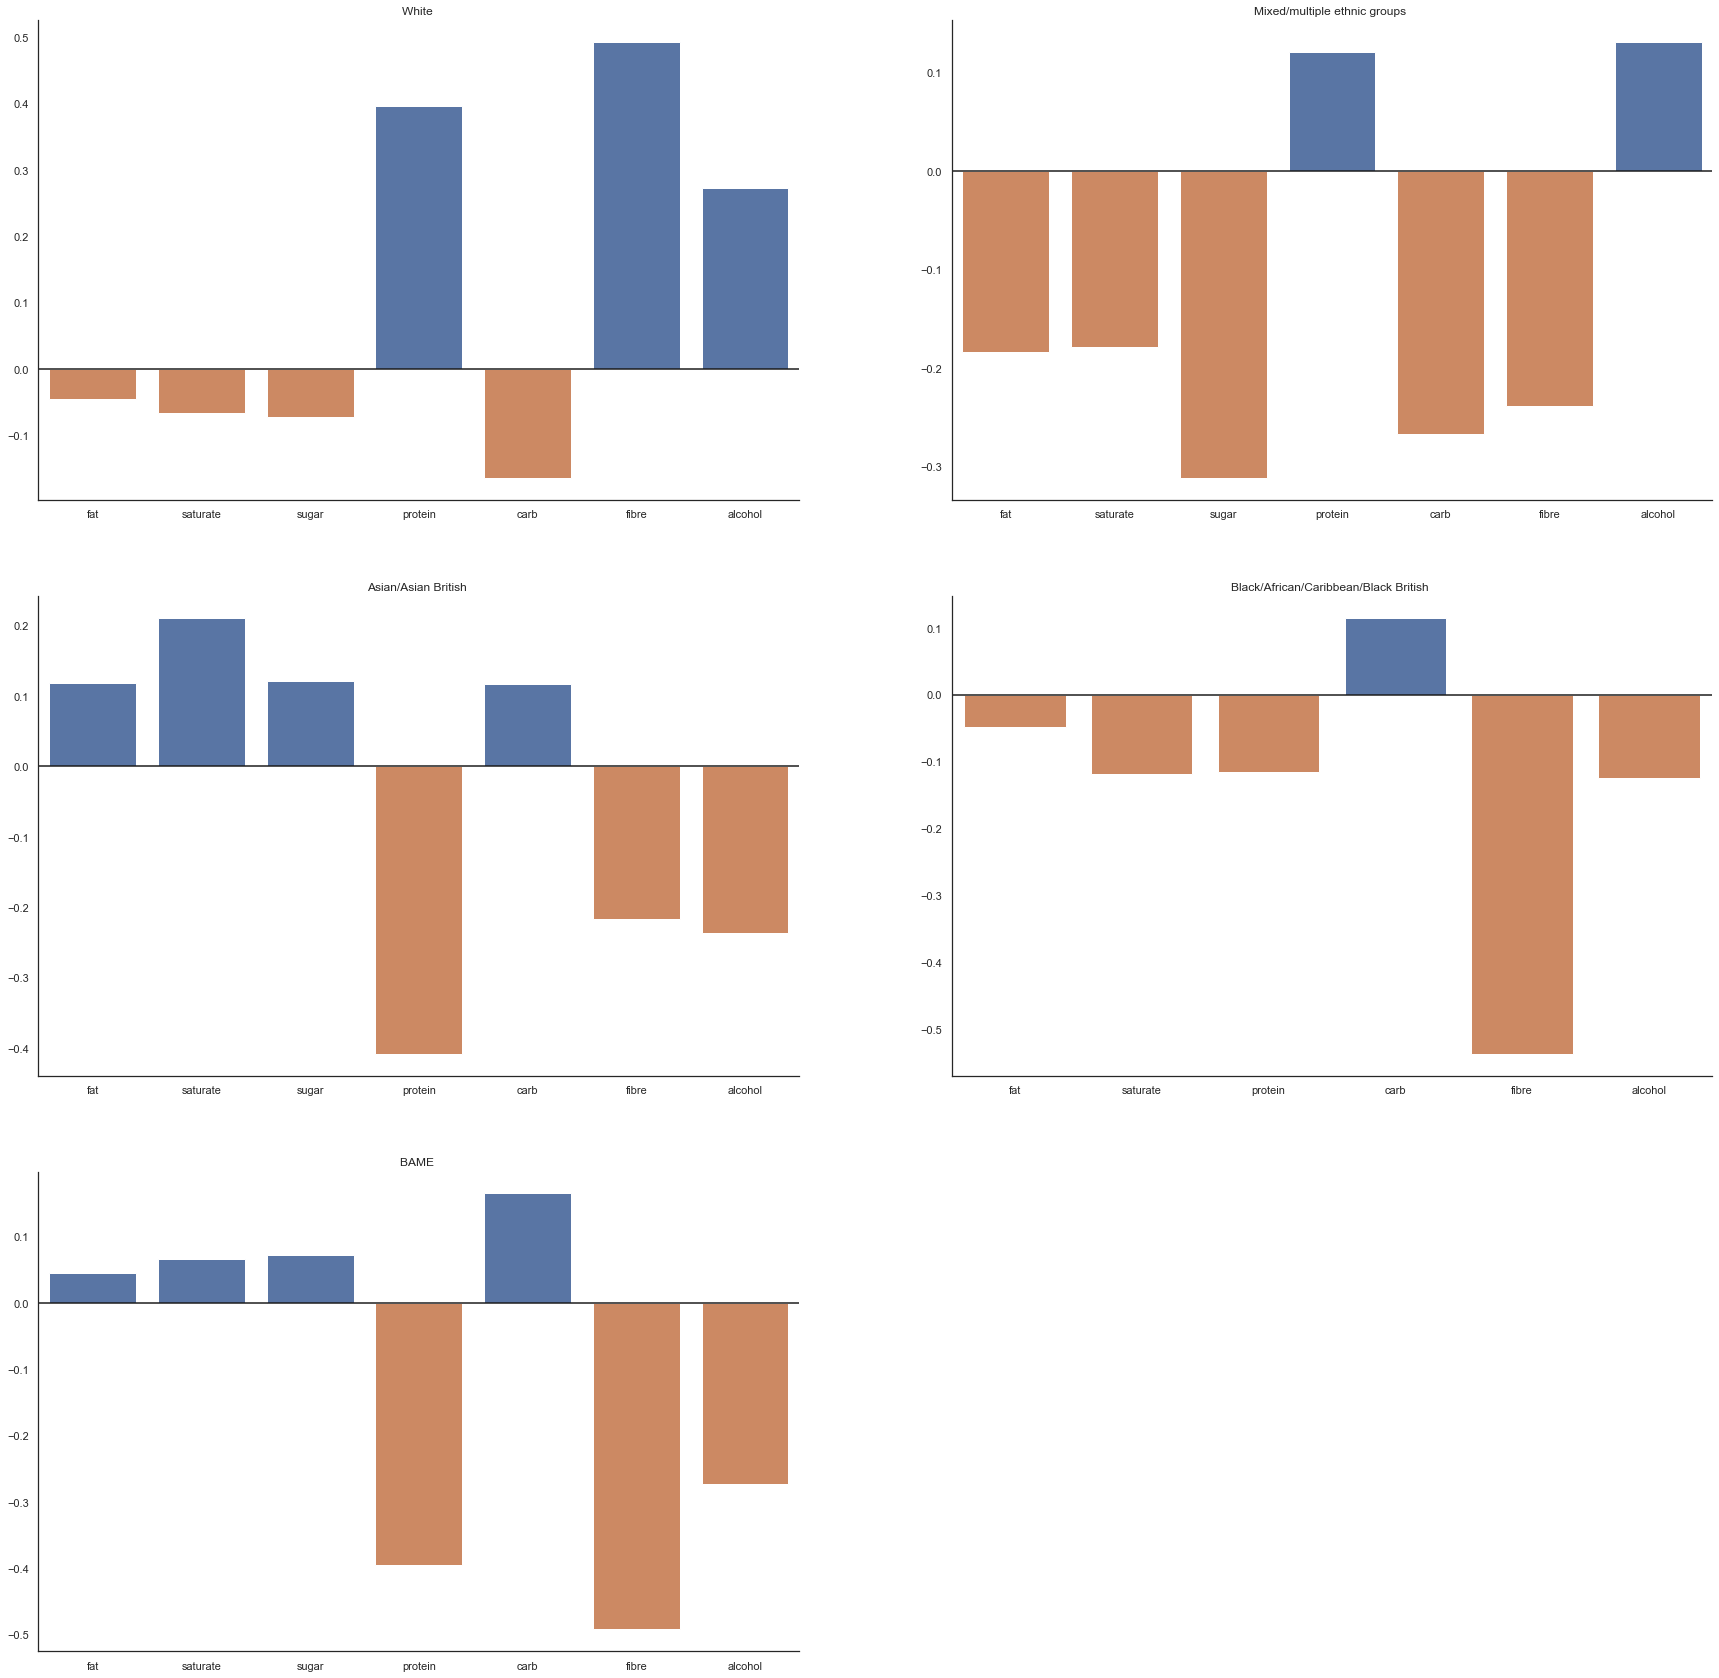

In [223]:
with sns.axes_style("white"): 

    f, axes = plt.subplots(3, 2, figsize=(30, 30))
    axes = axes.flatten()

    for ax, eth in zip(axes,ethnicities):
        correl = [(nutr, stats.spearmanr(a = lsoa_combined_year[eth], b = lsoa_combined_year[nutr]).correlation) for nutr in nutrients if stats.spearmanr(a = lsoa_combined_year[eth], b = lsoa_combined_year[nutr]).pvalue < 0.05]
        colors = [0 if c[1] >= 0 else 1 for c in correl]
        sns.barplot(x= [x[0].split("_")[1] for x in correl], y=[x[1] for x in correl], hue=colors, palette=sns.color_palette(), dodge=False, ax = ax)
        ax.axhline(0, ls='-', c = 'k')
        ax.get_legend().remove()
        ax.set_title(eth.split("perc")[0].replace("_", " "))

    sns.despine(top = True, right = True)
    axes[-1].set_visible(False)

plt.show()

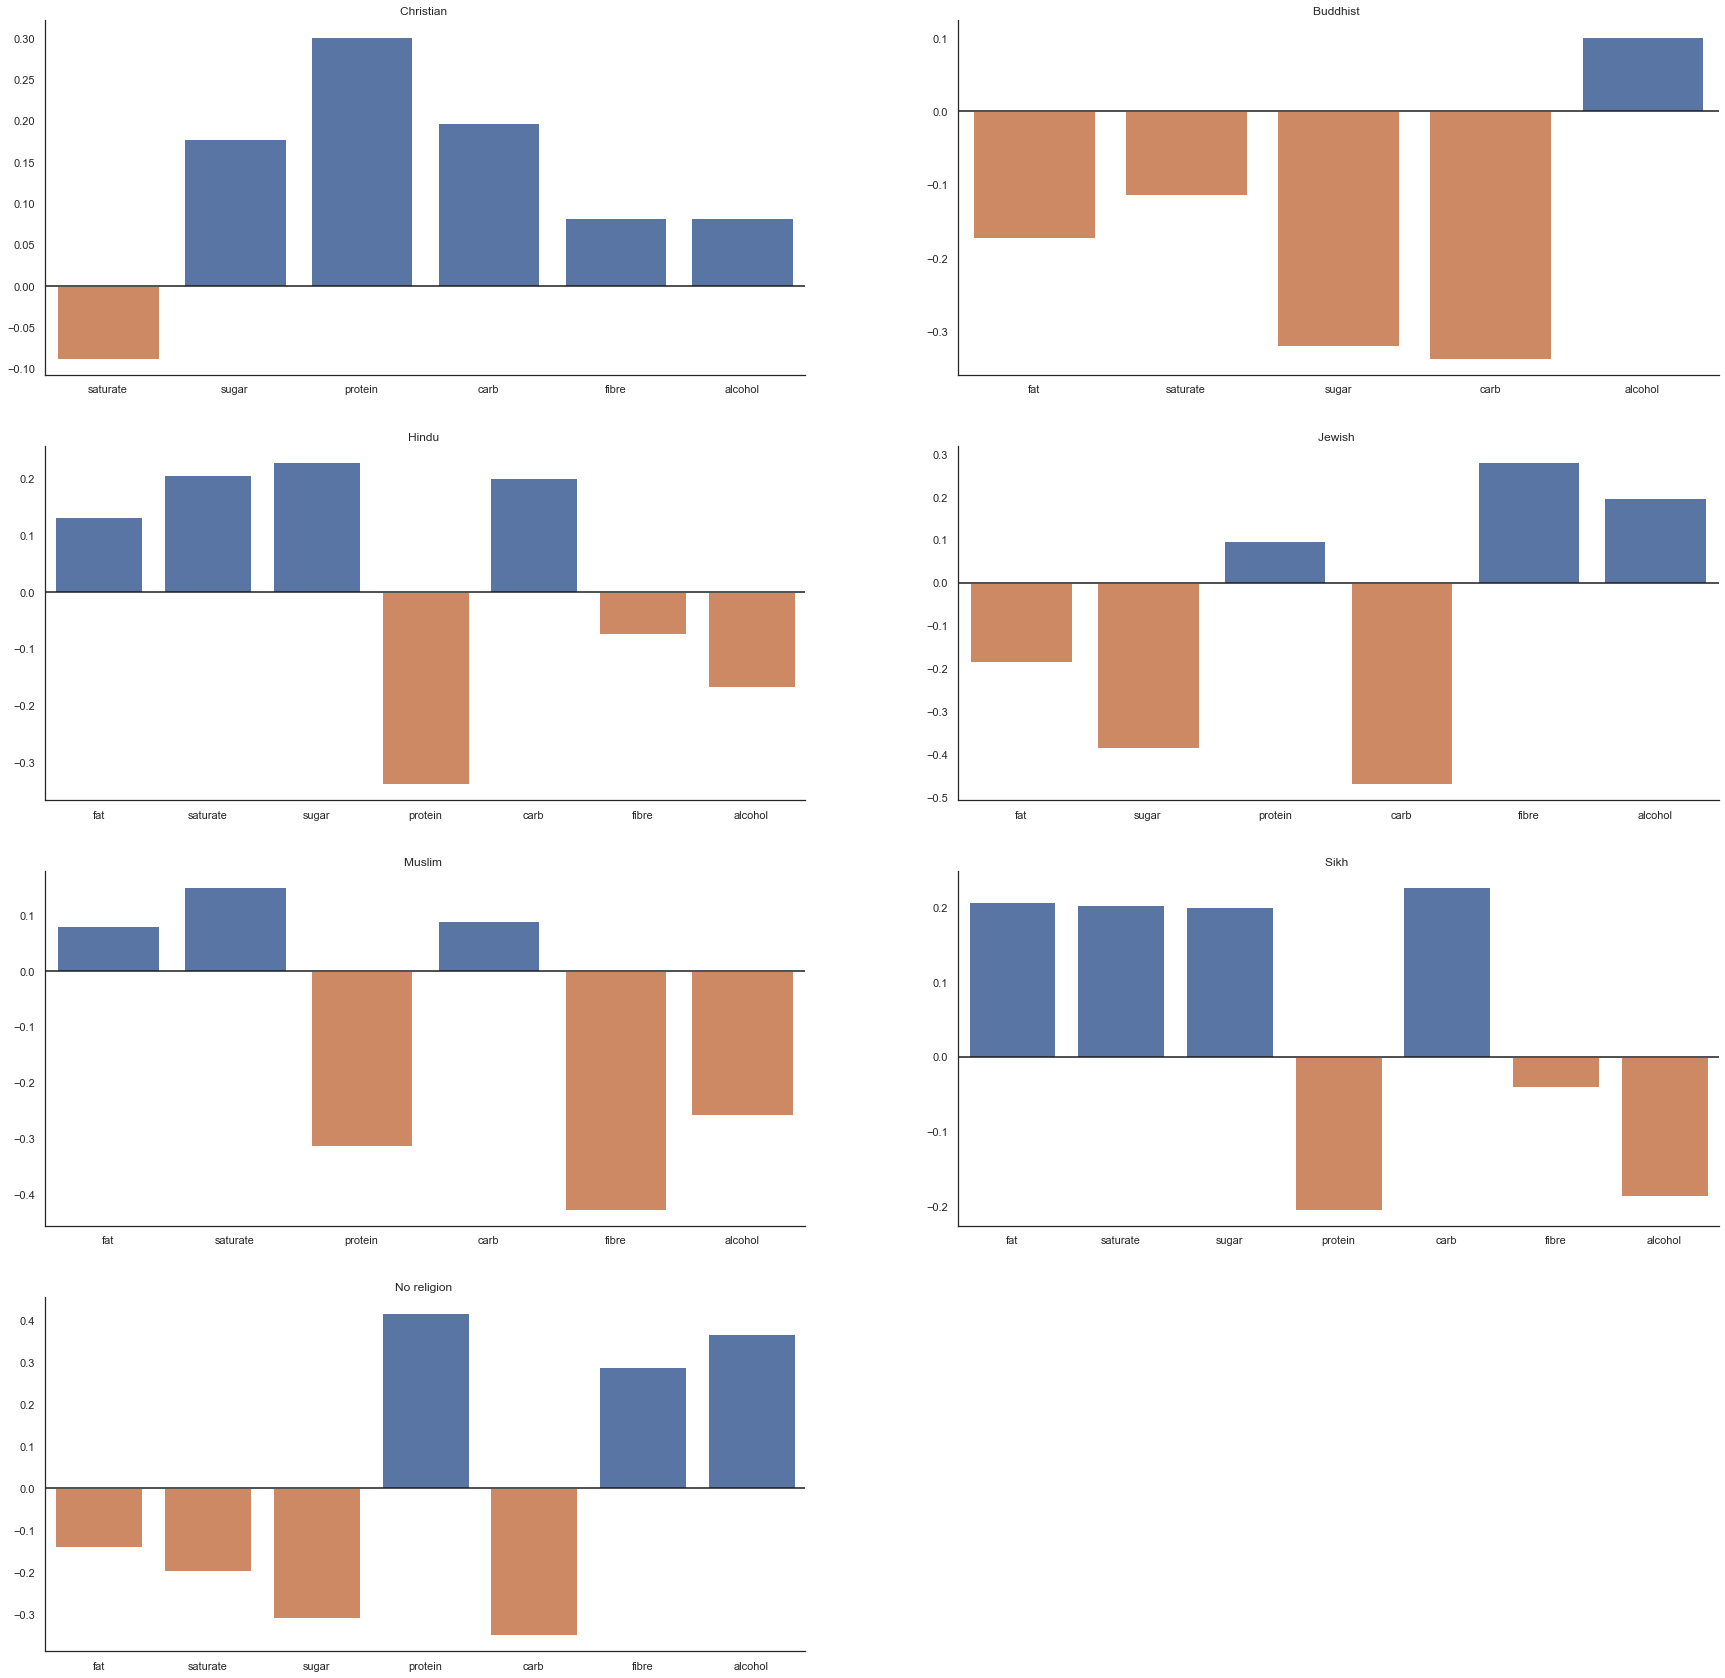

In [231]:
with sns.axes_style("white"): 

    f, axes = plt.subplots(4, 2, figsize=(30, 30))
    axes = axes.flatten()

    for ax, faith in zip(axes,religions):
        correl = [(nutr, stats.spearmanr(a = lsoa_combined_year[faith], b = lsoa_combined_year[nutr]).correlation) for nutr in nutrients if stats.spearmanr(a = lsoa_combined_year[faith], b = lsoa_combined_year[nutr]).pvalue < 0.05]
        colors = [0 if c[1] >= 0 else 1 for c in correl]
        sns.barplot(x= [x[0].split("_")[1] for x in correl], y=[x[1] for x in correl], hue=colors, palette=sns.color_palette(), dodge=False, ax = ax)
        ax.axhline(0, ls='-', c = 'k')
        ax.get_legend().remove()
        ax.set_title(faith.split("perc")[0].replace("_", " "))

    sns.despine(top = True, right = True)
    axes[-1].set_visible(False)

plt.show()

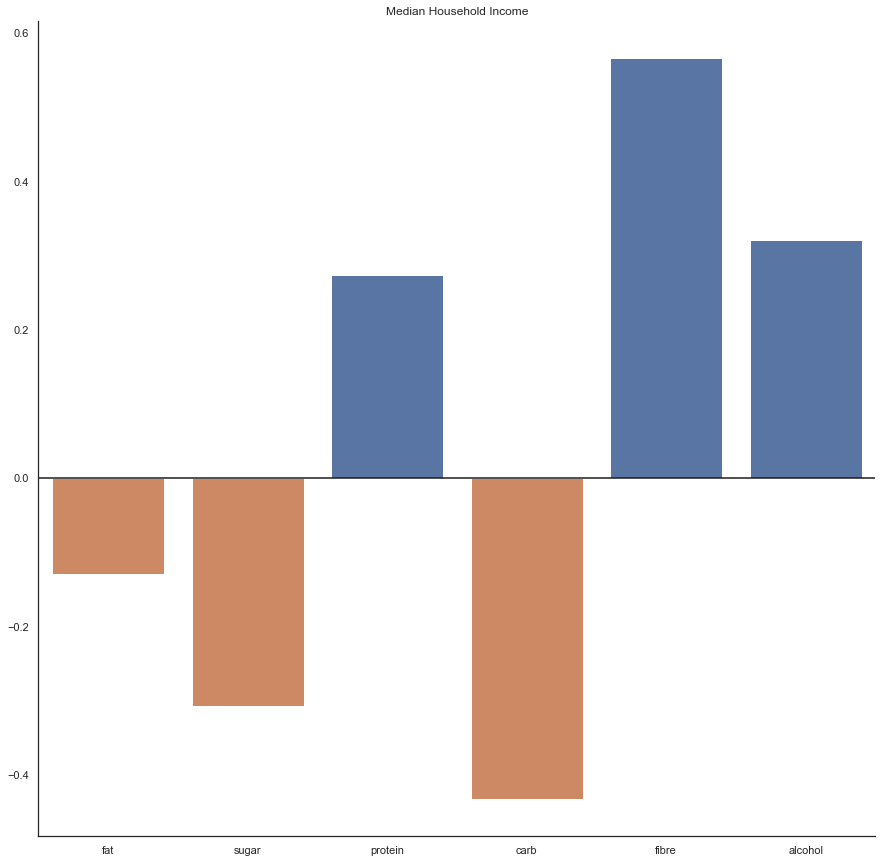

In [241]:

f, (ax) = plt.subplots(1, 1, figsize=(15, 15))
correl = [(nutr, stats.spearmanr(a = lsoa_combined_year["Median_Annual_Household_Income_estimate_pound"], b = lsoa_combined_year[nutr]).correlation) for nutr in nutrients if stats.spearmanr(a = lsoa_combined_year[faith], b = lsoa_combined_year[nutr]).pvalue < 0.05]
colors = [0 if c[1] >= 0 else 1 for c in correl]
sns.barplot(x= [x[0].split("_")[1] for x in correl], y=[x[1] for x in correl], hue=colors, palette=sns.color_palette(), dodge=False, ax = ax)
sns.despine(top = True, right = True)
ax.get_legend().remove()
ax.axhline(0, ls='-', c = 'k')
ax.set_title("Median Household Income")
plt.show()

In [ ]:
### Off to see the Wizard